<a href="https://colab.research.google.com/github/C242-AP02/APNR-ML/blob/main/OCR_NEW_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Library

In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 24.2 MB/s eta 0:00:00


In [ ]:
!ultralytics --version

WARNING ⚠️ argument '--version' does not require leading dashes '--', updating to 'version'.
8.3.44


## Import Library

In [ ]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
from huggingface_hub import login
from ultralytics import YOLO
from tqdm import tqdm
from PIL import Image
import os
import re
import cv2
import csv
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import transformers

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
print(transformers.__version__)

4.46.3


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Yolov8 Model

In [ ]:
# Muat model YOLO untuk deteksi bounding box plat nomor
yolo_model = YOLO('/content/best.pt')

## Load FineTune TrOCR Model

In [ ]:
processor = TrOCRProcessor.from_pretrained('rayyaa/finetune-trocr')
model = VisionEncoderDecoderModel.from_pretrained('rayyaa/finetune-trocr').to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.83k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

generation_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

## Call and Detect with OCR

In [ ]:
def read_and_show(image_path):
    """
    :param image_path: String, path to the input image.

    Returns:
        image: PIL Image.
    """
    image = Image.open(image_path).convert('RGB')
    return image

In [ ]:
def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.

    Returns:
        generated_text: the OCR'd text string.
    """
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [ ]:
def detect_plate(image):
    """
    Deteksi semua bounding box untuk plat nomor pada gambar.
    :param image: Gambar input dalam format PIL.
    :return: List of bounding boxes [[x_min, y_min, x_max, y_max], ...] atau None jika tidak ada.
    """
    results = yolo_model.predict(image, imgsz=640, conf=0.25)  # Deteksi dengan YOLO
    boxes = []
    if len(results[0].boxes) > 0:
        for box in results[0].boxes:
            boxes.append(box.xyxy[0].tolist())  # Tambahkan semua bounding box ke daftar
    return boxes if boxes else None

In [ ]:
# Membaca file CSV ke dictionary
plat_nomor_wilayah = {}
file_path = 'area_code.csv'

with open(file_path, mode='r', encoding='utf-8') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        kode = row['code'].strip().upper()  # Kolom 'code'
        area = row['area'].strip()         # Kolom 'area'
        plat_nomor_wilayah[kode] = area

def get_wilayah_from_plat(plat_text):
    """
    Fungsi untuk mendapatkan wilayah berdasarkan huruf awal plat nomor.
    :param plat_text: String, teks plat nomor yang dihasilkan model.
    :return: String, nama wilayah asal plat nomor.
    """
    # Mengekstrak kode wilayah (1 atau 2 huruf di awal)
    match = re.match(r'^[A-Z]{1,2}', plat_text.strip().upper())
    if match:
        kode_awal = match.group(0)
        return plat_nomor_wilayah.get(kode_awal, "Wilayah tidak ditemukan")

In [ ]:
def eval_new_data_with_location_with_yolo(
    data_path,
    num_samples=50
):
    """
    Evaluasi data gambar dengan bounding box dan ringkasan nomor plat serta wilayah.
    """
    image_paths = glob.glob(data_path)
    detected_plates = []  # Untuk menyimpan ringkasan nomor plat dan wilayah

    for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        if i == num_samples:
            break
        image = read_and_show(image_path)

        try:
            # Deteksi semua bounding box
            bboxes = detect_plate(image)
            if bboxes:
                cv_image = np.array(image)
                cv_image = cv2.cvtColor(cv_image, cv2.COLOR_RGB2BGR)

                for idx, bbox in enumerate(bboxes):
                    x_min, y_min, x_max, y_max = map(int, bbox)

                    # Ukuran bounding box
                    bbox_width = x_max - x_min
                    bbox_height = y_max - y_min
                    bbox_area = bbox_width * bbox_height

                    # Crop gambar pada setiap bounding box
                    cropped_image = image.crop((x_min, y_min, x_max, y_max))


                    try:
                        # OCR untuk setiap bounding box
                        text = ocr(cropped_image, processor, model)
                        print("text: ", text)
                        if text.strip():
                            wilayah = get_wilayah_from_plat(text)
                            detected_plates.append((text, wilayah))  # Simpan ringkasan
                        else:
                            text = "OCR gagal membaca"
                    except Exception as e:
                        text = "Deteksi gagal 1"

                    # Ukuran font dinamis berdasarkan ukuran bounding box
                    font_scale = max(0.5, min(1.0, bbox_area / (80000)))
                    thickness = max(1, int(font_scale * 3))

                    # Tambahkan bounding box
                    cv2.rectangle(cv_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

                    # Tambahkan teks hanya nomor plat di atas bounding box
                    text_x = max(x_min, 10)
                    text_y = max(y_min - 15, 20)
                    cv2.putText(
                        cv_image, f"Plat: {text}", (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX,
                        font_scale, (0, 255, 0), thickness, cv2.LINE_AA
                    )

                cv_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
            else:
                text = "Plat tidak terdeteksi"
                cv_image = np.array(image)

        except Exception as e:
            text = "Deteksi gagal 2"
            print(f"Error: {e}")
            cv_image = np.array(image)

        # Tampilkan gambar dengan bounding box dan hasil deteksi
        plt.figure(figsize=(7, 4))
        plt.imshow(cv_image)
        plt.axis('off')
        plt.show()

    # Buat ringkasan di latar putih
    if detected_plates:
        summary_image = np.ones((300, 800, 3), dtype=np.uint8) * 255
        y_offset = 20  # Awal posisi teks lebih rapat
        for idx, (plat, wilayah) in enumerate(detected_plates, start=1):
            text = f"{idx}. Plat: {plat}, Wilayah: {wilayah}"
            cv2.putText(
                summary_image, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (0, 0, 0), 1, cv2.LINE_AA  # Ukuran font kecil
            )
            y_offset += 20  # Jarak antar baris lebih kecil

        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(summary_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print("Tidak ada plat nomor yang terdeteksi.")


In [ ]:
import cv2
from PIL import Image

def enhance_image(frame):
    lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    enhanced_frame = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return enhanced_frame

def process_video_with_summary(video_path, processor, model, output_path="output_video.mp4"):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Tidak dapat membuka video.")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    detected_plates = []  # Menyimpan hasil deteksi

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = enhance_image(frame)
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        bboxes = detect_plate(image)  # Deteksi bounding box plat nomor
        if bboxes:
            for bbox in bboxes:
                x_min, y_min, x_max, y_max = map(int, bbox)
                cropped_image = image.crop((x_min, y_min, x_max, y_max))
                try:
                    text = ocr(cropped_image, processor, model)  # OCR untuk plat nomor
                    if text.strip():
                        wilayah = get_wilayah_from_plat(text)  # Ambil wilayah berdasarkan plat
                        detected_plates.append((text, wilayah))  # Simpan plat dan wilayah
                    else:
                        text = "OCR gagal membaca"
                except Exception as e:
                    text = f"Deteksi gagal: {e}"

                # Tambahkan bounding box dan teks ke frame
                frame = cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                text_x, text_y = x_min, y_min - 10
                if text_y < 0:
                    text_y = y_min + 20
                frame = cv2.putText(
                    frame, f"Plat: {text}", (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX,
                    1.2,  # Perbesar ukuran font
                    (0, 255, 0), 2, cv2.LINE_AA
                )

        out.write(frame)

    cap.release()
    out.release()

    # Tampilkan ringkasan deteksi di konsol
    print("\nRingkasan Deteksi:")
    if detected_plates:
        # Cetak daftar plat dan wilayah yang terdeteksi
        for idx, (plat, wilayah) in enumerate(detected_plates, start=1):
            print(f"{idx}. Plat: {plat}, Wilayah: {wilayah}")

        # Tampilkan daftar unik plat dan wilayah
        print("\nDaftar Unik Plat dan Wilayah yang Terdeteksi:")
        unique_detected = list(set(detected_plates))  # Buang duplikat
        for idx, (plat, wilayah) in enumerate(unique_detected, start=1):
            print(f"{idx}. Plat: {plat}, Wilayah: {wilayah}")
    else:
        print("Tidak ada plat nomor yang terdeteksi.")

    print(f"\nVideo hasil deteksi disimpan di: {output_path}")

## Test Model with New Data

In [ ]:
# Panggil fungsi evaluasi
eval_new_data_with_location_with_yolo(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'image_test', '*'),
    num_samples=100
)

  0%|          | 0/1 [00:00<?, ?it/s]


0: 384x640 1 number-plate, 102.4ms
Speed: 26.3ms preprocess, 102.4ms inference, 991.5ms postprocess per image at shape (1, 3, 384, 640)
text:  K 1411 KU


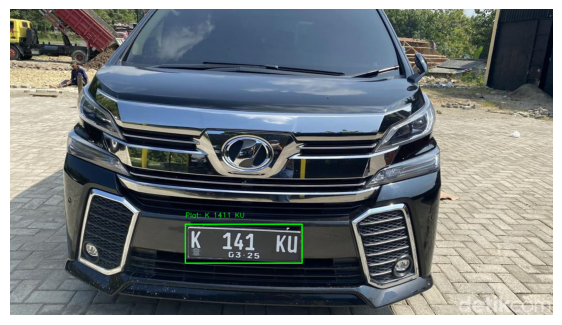

100%|██████████| 1/1 [00:04<00:00,  4.18s/it]


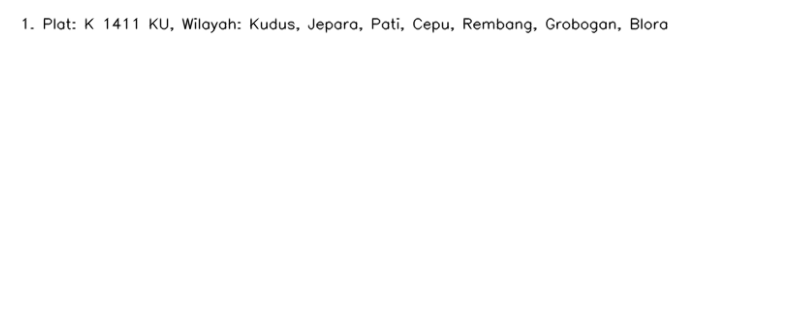

In [ ]:
image_paths = '/content/image1.jpeg'
eval_new_data_with_location_with_yolo(image_paths)

In [ ]:
# Panggil evaluasi video
process_video_with_summary(
    video_path="/content/testvideo1.mp4",
    processor=processor,
    model=model,
    output_path="/content/output_video.avi"
)



0: 640x384 1 number-plate, 44.1ms
Speed: 1.7ms preprocess, 44.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number-plate, 19.4ms
Speed: 1.7ms preprocess, 19.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number-plate, 18.7ms
Speed: 1.7ms preprocess, 18.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number-plate, 19.7ms
Speed: 2.2ms preprocess, 19.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number-plate, 19.3ms
Speed: 2.2ms preprocess, 19.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number-plate, 20.0ms
Speed: 1.7ms preprocess, 20.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number-plate, 19.8ms
Speed: 1.6ms preprocess, 19.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 number-plate, 20.3ms
Speed: 1.6ms preprocess, 20.3ms inference